In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras

In [12]:
from keras.models import Sequential,Model
from keras.layers import Add,Dense,Conv1D,MaxPooling1D,AveragePooling1D,Flatten,GlobalMaxPooling1D,Dropout,BatchNormalization,Input,Activation,GlobalAveragePooling1D

In [56]:
from keras import callbacks

In [2]:
from tcn import TCN, tcn_full_summary

In [3]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import StratifiedKFold

In [4]:
train_features = pd.read_csv('D:\\ML\\DL Repo\\tabular-playground-series-apr-2022\\data\\train.csv')
train_labels = pd.read_csv('D:\\ML\\DL Repo\\tabular-playground-series-apr-2022\\data\\train_labels.csv')

In [5]:
X = train_features.drop(['sequence','subject','step'],axis=1)
X.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359


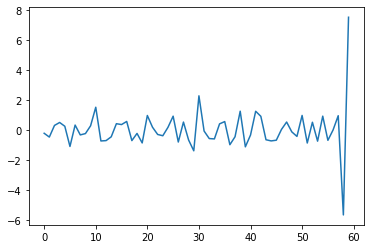

In [6]:
X = np.array(X).reshape(-1,60,13)
plt.plot(X[0,:,0])

In [7]:
y = np.array(train_labels['state']).reshape((len(train_labels['state']),1))
y.shape

(25968, 1)

In [8]:
X.shape

(25968, 60, 13)

In [14]:
idx = np.random.permutation(len(X))
X_train = X[idx]
y_train = y[idx]

In [57]:
callbacks = [callbacks.ModelCheckpoint("D:\\ML\\DL Repo\\tabular-playground-series-apr-2022\\model\\best_model.h5", save_best_only=True, monitor="val_loss"),
             callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
             callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=1)]

In [130]:
input_layer = Input((60,13))
input_layer = BatchNormalization()(input_layer)

conv1 = Conv1D(filters=256, kernel_size=3, use_bias=False,padding='same',dilation_rate=1)(input_layer)
conv1 = BatchNormalization()(conv1)
conv1 = Activation(activation='relu')(conv1)
conv1 = Dropout(0.2)(conv1)

conv2 = Conv1D(filters=256, kernel_size=3, use_bias=False,padding='same',dilation_rate=1)(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
conv2 = Dropout(0.2)(conv2)

conv3 = Conv1D(filters=256, kernel_size=3, use_bias=False,padding='same',dilation_rate=1)(conv2)
conv3 = BatchNormalization()(conv3)
conv3 = Activation(activation='relu')(conv3)
conv3 = Dropout(0.2)(conv3)

pool1 = MaxPooling1D(2,1)(conv3)
pool1 = BatchNormalization()(pool1)

conv4 = Conv1D(filters=64, kernel_size=3, use_bias=False,padding='same',dilation_rate=1)(pool1)
conv4 = BatchNormalization()(conv4)
conv4 = Activation(activation='relu')(conv4)
conv4 = Dropout(0.2)(conv4)

conv5 = Conv1D(filters=64, kernel_size=3, use_bias=False,padding='same',dilation_rate=1)(conv4)
conv5 = BatchNormalization()(conv5)
conv5 = Activation('relu')(conv5)
conv5 = Dropout(0.2)(conv5)

conv6 = Conv1D(filters=64, kernel_size=3, use_bias=False,padding='same',dilation_rate=1)(conv5)
conv6 = BatchNormalization()(conv6)
conv6 = Activation(activation='relu')(conv6)
conv6 = Dropout(0.2)(conv6)

gap_layer = GlobalAveragePooling1D()(conv6)
gap_layer = BatchNormalization()(gap_layer)
#gap_layer = Flatten()(gap_layer)
gap_layer = Dropout(0.5)(gap_layer)

output_layer = Dense(1, activation='sigmoid')(gap_layer)
model = Model(inputs=input_layer, outputs=output_layer)

In [131]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [132]:
clf = KerasClassifier(model)

In [133]:
cv = StratifiedKFold(n_splits=10,random_state=42,shuffle=True)

In [134]:
for train_index, test_index in cv.split(X, y):
    x_train_fold, x_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    clf.fit(x_train_fold, y_train_fold,epochs=5,batch_size=128)
    print(clf.score(x_test_fold, y_test_fold))

Epoch 1/5
183/183 [==============================] - 5s 17ms/step - loss: 0.7779 - accuracy: 0.5547
Epoch 2/5
183/183 [==============================] - 3s 16ms/step - loss: 0.6896 - accuracy: 0.6283
Epoch 3/5
183/183 [==============================] - 3s 17ms/step - loss: 0.6058 - accuracy: 0.6988
Epoch 4/5
183/183 [==============================] - 3s 17ms/step - loss: 0.5271 - accuracy: 0.7503
Epoch 5/5
82/82 [==============================] - 0s 3ms/step
0.7855217558721602
Epoch 1/5
183/183 [==============================] - 3s 17ms/step - loss: 0.4339 - accuracy: 0.8021
Epoch 2/5
183/183 [==============================] - 3s 17ms/step - loss: 0.4044 - accuracy: 0.8180
Epoch 3/5
183/183 [==============================] - 3s 17ms/step - loss: 0.3926 - accuracy: 0.8208
Epoch 4/5
183/183 [==============================] - 3s 17ms/step - loss: 0.3803 - accuracy: 0.8317
Epoch 5/5
82/82 [==============================] - 0s 3ms/step
0.8386599922988063
Epoch 1/5
183/183 [=================

In [135]:
history=model.fit(X_train,y_train,validation_split=0.2,epochs=500,batch_size=128,callbacks=callbacks)

Epoch 1/500
163/163 [==============================] - 4s 20ms/step - loss: 0.1902 - accuracy: 0.9230 - val_loss: 0.1200 - val_accuracy: 0.9501 - lr: 0.0010
Epoch 2/500
163/163 [==============================] - 3s 18ms/step - loss: 0.1794 - accuracy: 0.9270 - val_loss: 0.1319 - val_accuracy: 0.9474 - lr: 0.0010
Epoch 3/500
163/163 [==============================] - 3s 18ms/step - loss: 0.1801 - accuracy: 0.9266 - val_loss: 0.1527 - val_accuracy: 0.9386 - lr: 0.0010
Epoch 4/500
163/163 [==============================] - 3s 18ms/step - loss: 0.1774 - accuracy: 0.9287 - val_loss: 0.1472 - val_accuracy: 0.9386 - lr: 0.0010
Epoch 5/500
163/163 [==============================] - 3s 18ms/step - loss: 0.1706 - accuracy: 0.9328 - val_loss: 0.1485 - val_accuracy: 0.9363 - lr: 0.0010
Epoch 6/500
163/163 [==============================] - 3s 17ms/step - loss: 0.1666 - accuracy: 0.9325 - val_loss: 0.1799 - val_accuracy: 0.9241 - lr: 0.0010
Epoch 7/500
163/163 [==============================] - 3s 

In [102]:
model = keras.models.load_model('D:\\ML\DL Repo\\tabular-playground-series-apr-2022\\model\\best_model.h5')

In [103]:
test = pd.read_csv('D:\\ML\\tabular-playground-series-apr-2022\\test.csv')
test_X = test.drop(['sequence','subject','step'],axis=1)
Seq = test.groupby('sequence').sum().index
test_X = np.array(test_X).reshape((-1,60,13))

In [104]:
test_y = model_1.predict(test_X)

In [105]:
test_y = np.int16(np.squeeze(test_y)>0.5)
test_data = pd.DataFrame(Seq,columns=['sequence'])
test_data['state'] = test_y
test_data.head()

,sequence,state
0,25968,1
1,25969,1
2,25970,0
3,25971,1
4,25972,1


In [106]:
test_data.to_csv('D:\\ML\\DL Repo\\tabular-playground-series-apr-2022\\out\\my_submission_file.csv', index=False)

# TCN 

In [126]:
tcn_layer = TCN(input_shape=(60,13),
    dropout_rate=0.2)
tcn_layer.receptive_field

253

In [127]:
tcn_model = Sequential()
tcn_model.add(tcn_layer)
tcn_model.add(Dense(1, activation='sigmoid'))

In [128]:
tcn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [129]:
tcn_model.fit(X_train,y_train,validation_split=0.2,epochs=500,batch_size=128,callbacks=callbacks)

Epoch 1/500
163/163 [==============================] - 4s 15ms/step - loss: 7.7405 - accuracy: 0.5101 - val_loss: 1.6165 - val_accuracy: 0.5268 - lr: 0.0010
Epoch 2/500
163/163 [==============================] - 3s 15ms/step - loss: 2.2277 - accuracy: 0.5230 - val_loss: 1.1640 - val_accuracy: 0.5187 - lr: 0.0010
Epoch 3/500
163/163 [==============================] - 2s 13ms/step - loss: 1.4771 - accuracy: 0.5382 - val_loss: 0.9429 - val_accuracy: 0.5281 - lr: 0.0010
Epoch 4/500
163/163 [==============================] - 2s 13ms/step - loss: 1.1618 - accuracy: 0.5300 - val_loss: 0.8198 - val_accuracy: 0.5420 - lr: 0.0010
Epoch 5/500
163/163 [==============================] - 3s 15ms/step - loss: 0.9703 - accuracy: 0.5327 - val_loss: 0.7537 - val_accuracy: 0.5485 - lr: 0.0010
Epoch 6/500
163/163 [==============================] - 2s 15ms/step - loss: 0.8507 - accuracy: 0.5400 - val_loss: 0.7308 - val_accuracy: 0.5504 - lr: 0.0010
Epoch 7/500
163/163 [==============================] - 2s 

Epoch 53/500
163/163 [==============================] - 2s 15ms/step - loss: 0.5478 - accuracy: 0.7138 - val_loss: 0.6760 - val_accuracy: 0.6261 - lr: 0.0010
Epoch 54/500
163/163 [==============================] - 2s 15ms/step - loss: 0.5487 - accuracy: 0.7148 - val_loss: 0.6633 - val_accuracy: 0.6344 - lr: 0.0010
Epoch 55/500
163/163 [==============================] - 2s 15ms/step - loss: 0.5389 - accuracy: 0.7190 - val_loss: 0.6694 - val_accuracy: 0.6327 - lr: 0.0010
Epoch 56/500
163/163 [==============================] - 2s 15ms/step - loss: 0.5277 - accuracy: 0.7301 - val_loss: 0.6771 - val_accuracy: 0.6396 - lr: 0.0010
Epoch 57/500
163/163 [==============================] - 2s 15ms/step - loss: 0.5278 - accuracy: 0.7287 - val_loss: 0.6731 - val_accuracy: 0.6278 - lr: 0.0010
Epoch 58/500
163/163 [==============================] - 2s 15ms/step - loss: 0.5241 - accuracy: 0.7282 - val_loss: 0.6760 - val_accuracy: 0.6315 - lr: 0.0010
Epoch 59/500
163/163 [==============================